# CNN Autoencoder

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
directory = '/teamspace/studios/this_studio/time-series-anomaly-detection'
if os.path.exists(directory):
    os.chdir(directory)

from data.dataset_utils import load_data, preprocess, Subjects, prepare_data, get_dataloader, get_dataloaders_subject_specific
from _3_autoencoder.plot import plot_losses_and_auc, plot_histogram
from _3_autoencoder.models.cnn_autoencoder import ECG_CNNAutoencoder, EDA_CNN, ECG_CNN, EMG_CNN, CNN
from _3_autoencoder.test import report, leave_one_subject_out_CV, subject_specific_CV, random_search

## ECG with context

In [2]:
df = load_data(filtered=True)
df = preprocess(df, emg_envelope=True, resample_length=2816/2)

In [89]:
batch_size = 64
mp_filter = 0.25
k=7
signals = ['ecg']

# for training
train_data_normal, _ = prepare_data(df, signals, classes=[0], train_subjects=Subjects.train, test_subjects=Subjects.val, mp_filter=mp_filter)
train_loader_normal = get_dataloader(train_data_normal, batch_size=batch_size, shuffle=True,  k=k)

# for validation
_, test_data = prepare_data(df, signals, classes=[0, 4], train_subjects=Subjects.train, test_subjects=Subjects.val, mp_filter=mp_filter)
test_loader = get_dataloader(test_data, batch_size=batch_size, shuffle=False , k=k)

# for testing with training data
_, val_train_data = prepare_data(df, train_subjects=Subjects.val, test_subjects=Subjects.all, signals=signals, classes=[0, 4], mp_filter=mp_filter)
val_train_loader = get_dataloader(val_train_data, batch_size=batch_size, shuffle=False, k=k)

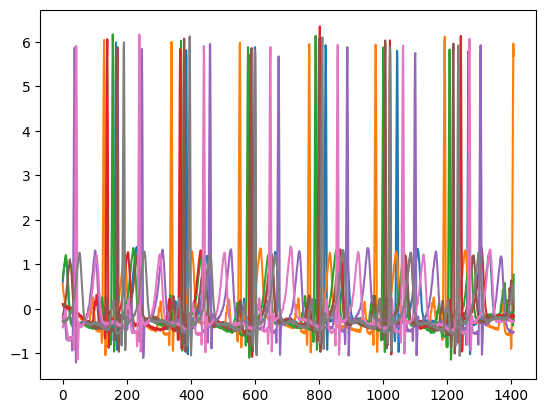

Epoch 1/100 - Train loss: 1.0044 - Val loss normal: 0.9643 - Val loss anomaly: 0.9781 - Val AUC: 0.5063
Epoch 2/100 - Train loss: 0.9755 - Val loss normal: 0.9561 - Val loss anomaly: 0.9691 - Val AUC: 0.5064
Epoch 3/100 - Train loss: 0.9634 - Val loss normal: 0.9200 - Val loss anomaly: 0.9320 - Val AUC: 0.5052
Epoch 4/100 - Train loss: 0.9229 - Val loss normal: 0.8915 - Val loss anomaly: 0.9091 - Val AUC: 0.5055
Epoch 5/100 - Train loss: 0.8781 - Val loss normal: 0.8429 - Val loss anomaly: 0.8916 - Val AUC: 0.5397
Epoch 6/100 - Train loss: 0.8323 - Val loss normal: 0.8376 - Val loss anomaly: 0.8280 - Val AUC: 0.4816
Epoch 7/100 - Train loss: 0.8012 - Val loss normal: 0.7265 - Val loss anomaly: 0.7484 - Val AUC: 0.5198
Epoch 8/100 - Train loss: 0.7607 - Val loss normal: 0.8870 - Val loss anomaly: 0.8903 - Val AUC: 0.4990
Epoch 9/100 - Train loss: 0.7237 - Val loss normal: 0.7162 - Val loss anomaly: 0.7655 - Val AUC: 0.5189
Epoch 10/100 - Train loss: 0.6952 - Val loss normal: 0.5438 - Va

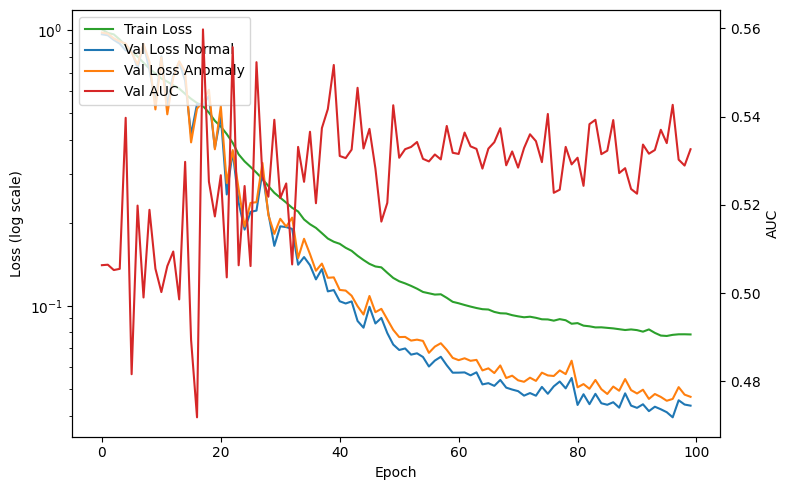

Best AUC: 0.5598 at epoch 18


In [90]:
ecg_config = {
    'crop_size': 0,
    #'add_noise_channels': [0, 1, 2, 3],
    #'max_noise': 0.1,
    'conv': {'ker': 11, 'pad': 5},
    'enc_dropout': 0.1,
    'dec_dropout': 0.1,
    'activation': 'relu',
    'batch_norm': False,
    'latent_dim': 64,
    'lr': 1e-3,
    'batch_size': 128,
    'epochs': 100,
    'mp_filter': 0.25,
    'print': True,
    'contains_context': True,

}

model = ECG_CNNAutoencoder(ecg_config)
train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores, evaluation = model.train_model(train_loader_normal, val_loader=test_loader)
plot_losses_and_auc(train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores)

Ground truth: 0
Reconstruction error: 0.02291415072977543


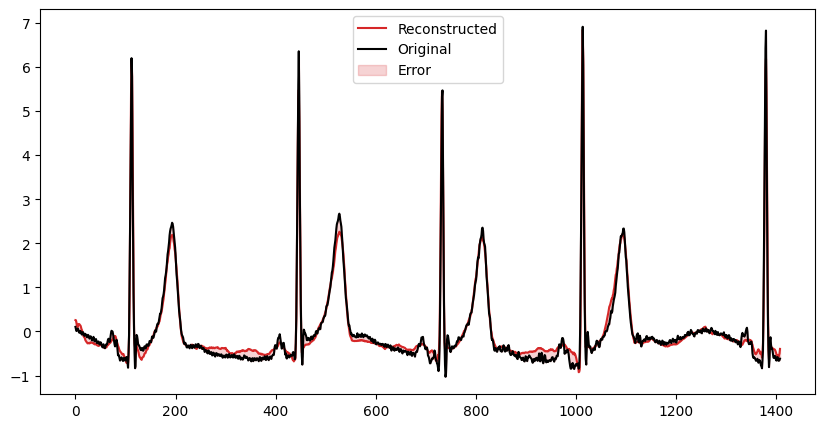

In [96]:
loader = get_dataloader(test_data, batch_size=1, shuffle=True, k=7)
signals, labels = next(iter(loader))

print(f'Ground truth: {int(labels[0].item())}')
model.plot_reconstruction(signals, index=0)

## EDA

In [ ]:
df = load_data(filtered=True)
df = preprocess(df, resample_length=2816/16) # 176

In [50]:
batch_size = 128
mp_filter = 0.25
k=0
signals = ['gsr']

# for training
train_data_normal, _ = prepare_data(df, signals, classes=[0], train_subjects=Subjects.train, test_subjects=Subjects.val, mp_filter=mp_filter)
train_loader_normal = get_dataloader(train_data_normal, batch_size=batch_size, shuffle=True,  k=k)

# for validation
_, test_data = prepare_data(df, signals, classes=[0, 4], train_subjects=Subjects.train, test_subjects=Subjects.val, mp_filter=mp_filter)
test_loader = get_dataloader(test_data, batch_size=batch_size, shuffle=False , k=k)

# for testing with training data
_, val_train_data = prepare_data(df, train_subjects=Subjects.val, test_subjects=Subjects.all, signals=signals, classes=[0, 4], mp_filter=mp_filter)
val_train_loader = get_dataloader(val_train_data, batch_size=batch_size, shuffle=False, k=k)

In [ ]:
eda_config = {
    'crop_size': 88,
    'crop_begin': True,
    'conv': {'ker': 3, 'pad': 1},
    'enc_dropout': 0,
    'dec_dropout': 0,
    'activation': 'relu',
    'batch_norm': False,
    'latent_dim': 1,
    'lr': 1e-3,
    'batch_size': 128,
    'epochs': 100,
    'mp_filter': 0.25,
    'print': False,
    'contains_context': False,
}

model = EDA_CNN(eda_config)
train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores, evaluation = model.train_model(train_loader_normal, val_loader=test_loader)

Epoch 1/100 - Train loss: 1.0244 - Val loss normal: 0.7868 - Val loss anomaly: 0.9706 - Val AUC: 0.4741
Epoch 2/100 - Train loss: 1.0039 - Val loss normal: 0.7508 - Val loss anomaly: 0.9360 - Val AUC: 0.4744
Epoch 3/100 - Train loss: 0.9818 - Val loss normal: 0.7247 - Val loss anomaly: 0.9114 - Val AUC: 0.4753
Epoch 4/100 - Train loss: 0.9873 - Val loss normal: 0.6917 - Val loss anomaly: 0.8783 - Val AUC: 0.4768
Epoch 5/100 - Train loss: 0.9594 - Val loss normal: 0.6118 - Val loss anomaly: 0.7977 - Val AUC: 0.4792
Epoch 6/100 - Train loss: 0.9818 - Val loss normal: 0.5178 - Val loss anomaly: 0.7002 - Val AUC: 0.4818
Epoch 7/100 - Train loss: 0.7275 - Val loss normal: 0.4506 - Val loss anomaly: 0.6252 - Val AUC: 0.4790
Epoch 8/100 - Train loss: 0.7498 - Val loss normal: 0.3988 - Val loss anomaly: 0.5632 - Val AUC: 0.4890
Epoch 9/100 - Train loss: 0.5608 - Val loss normal: 0.3237 - Val loss anomaly: 0.4656 - Val AUC: 0.5279
Epoch 10/100 - Train loss: 0.4355 - Val loss normal: 0.2130 - Va

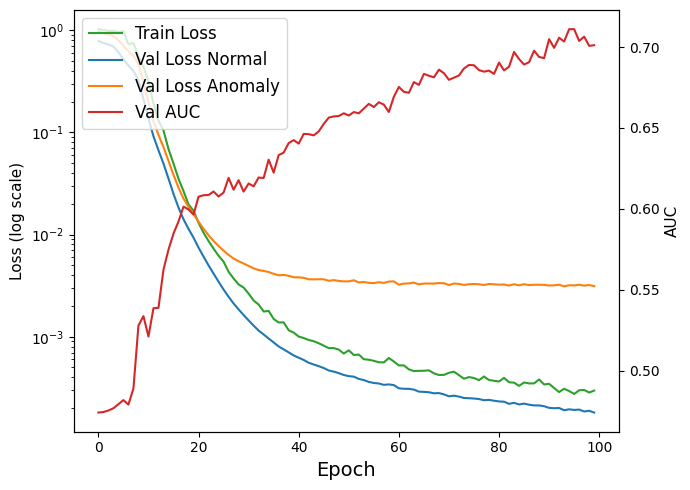

Best AUC: 0.7111 at epoch 96


In [ ]:
plot_losses_and_auc(train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores)

Ground truth: 1
Reconstruction error: 0.001262812060303986


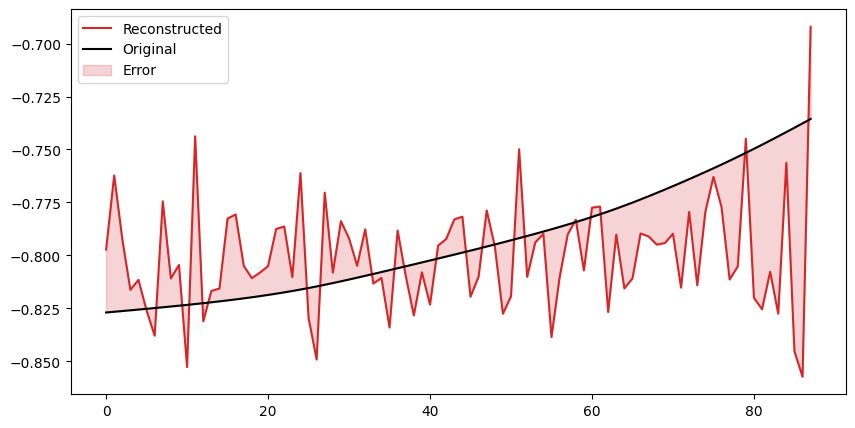

In [39]:
loader = get_dataloader(test_data, batch_size=1, shuffle=True, k=0)
signals, labels = next(iter(loader))

print(f'Ground truth: {int(labels[0].item())}')
model.plot_reconstruction(signals, index=0)

In [ ]:
evals_test, evals_train = leave_one_subject_out_CV(model=EDA_CNN, config=eda_config, signals=['gsr'], batch_size=ecg_config['batch_size'], mp_filter=ecg_config['mp_filter'], resample_length=2816/16)
report(evals_test, evals_train, percentile=85)

method       acc                prec            \
                              NaN       avg       std       avg       std   
0   test_supervised_acc_threshold  0.825862  0.145944  0.880023  0.133591   
1  train_supervised_acc_threshold  0.696839  0.176240  0.680257  0.370461   
2      fixed_percentile_threshold  0.674138  0.172892  0.673316  0.370604   
3                mixmod_threshold  0.514080  0.060256  0.103448  0.304543   
4                filter_threshold  0.502874  0.021584  0.034483  0.182466   
5                 karch_threshold  0.507471  0.039230  0.057471  0.232741   
6                    eb_threshold  0.500287  0.002665  0.011494  0.106593   

        rec                 auc           threshold           percentile  \
        avg       std       avg       std       avg       std        avg   
0  0.779885  0.251942  0.816983  0.187006  0.000810  0.002401  82.183908   
1  0.558621  0.405438  0.816983  0.187006  0.000559  0.000263  85.634857   
2  0.533333  0.413887  0.816983  0.187006  0.000578  0.000557        NaN   
3  0.028736  0.120256  0.816983  0.187006  0.045781  0.026541        NaN   
4  0.005747  0.043169  0.816983  0.187006  0.099483  0.020454        NaN   
5  0.014943  0.078460  0.816983  0.187006  0.071484  0.013077        NaN   
6  0.000575  0.005330  0.816983  0.187006  0.349501  0.018318        NaN   

              
         std  
0  19.218961  
1   9.225210  
2        NaN  
3        NaN  
4        NaN  
5        NaN  
6        NaN

## EMG

In [ ]:
df = load_data(filtered=True)
df = preprocess(df, emg_envelope=True, resample_length=2816/4) # 704

In [4]:
batch_size = 128
mp_filter = 0.25
k=0
signals = ['emg_trapezius']

# for training
train_data_normal, _ = prepare_data(df, signals, classes=[0], train_subjects=Subjects.train, test_subjects=Subjects.val, mp_filter=mp_filter)
train_loader_normal = get_dataloader(train_data_normal, batch_size=batch_size, shuffle=True,  k=k)

# for validation
_, test_data = prepare_data(df, signals, classes=[0, 4], train_subjects=Subjects.train, test_subjects=Subjects.val, mp_filter=mp_filter)
test_loader = get_dataloader(test_data, batch_size=batch_size, shuffle=False , k=k)

# for testing with training data
_, val_train_data = prepare_data(df, train_subjects=Subjects.val, test_subjects=Subjects.all, signals=signals, classes=[0, 4], mp_filter=mp_filter)
val_train_loader = get_dataloader(val_train_data, batch_size=batch_size, shuffle=False, k=k)

Epoch 1/15 - Train loss: 0.3044 - Val loss normal: 2.0716 - Val loss anomaly: 4.1604 - Val AUC: 0.5248
Epoch 2/15 - Train loss: 0.2942 - Val loss normal: 1.9953 - Val loss anomaly: 4.0459 - Val AUC: 0.5605
Epoch 3/15 - Train loss: 0.1855 - Val loss normal: 0.9378 - Val loss anomaly: 2.3657 - Val AUC: 0.5722
Epoch 4/15 - Train loss: 0.0877 - Val loss normal: 0.7400 - Val loss anomaly: 2.0382 - Val AUC: 0.5736
Epoch 5/15 - Train loss: 0.0717 - Val loss normal: 0.6770 - Val loss anomaly: 1.9306 - Val AUC: 0.5777
Epoch 6/15 - Train loss: 0.0635 - Val loss normal: 0.7741 - Val loss anomaly: 2.0978 - Val AUC: 0.5808
Epoch 7/15 - Train loss: 0.0594 - Val loss normal: 0.7894 - Val loss anomaly: 2.1051 - Val AUC: 0.5790
Epoch 8/15 - Train loss: 0.0655 - Val loss normal: 0.6607 - Val loss anomaly: 1.8848 - Val AUC: 0.5793
Epoch 9/15 - Train loss: 0.0624 - Val loss normal: 0.6241 - Val loss anomaly: 1.8061 - Val AUC: 0.5798
Epoch 10/15 - Train loss: 0.0498 - Val loss normal: 0.6937 - Val loss ano

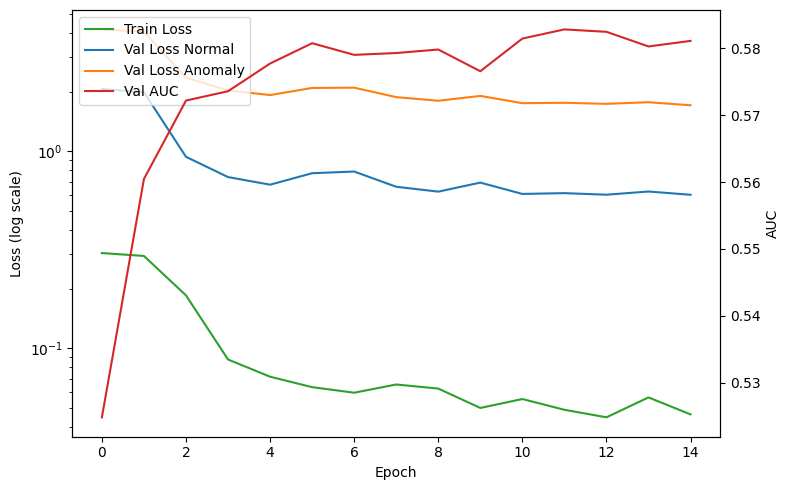

Best AUC: 0.5828 at epoch 12


In [60]:
emg_config = {
    'crop_size': 0,
    'crop_begin': True,
    'conv': {'ker': 11, 'pad': 5},
    'enc_dropout': 0,
    'dec_dropout': 0,
    'activation': 'relu',
    'batch_norm': False,
    'latent_dim': 2,
    'lr': 1e-3,
    'batch_size': 128,
    'epochs': 15,
    'mp_filter': 0.25,
    'print': False,
    'contains_context': False,
}

model = EMG_CNN(emg_config)
train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores, evaluation = model.train_model(train_loader_normal, val_loader=test_loader)
plot_losses_and_auc(train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores)

Ground truth: 1
Reconstruction error: 0.08077308535575867


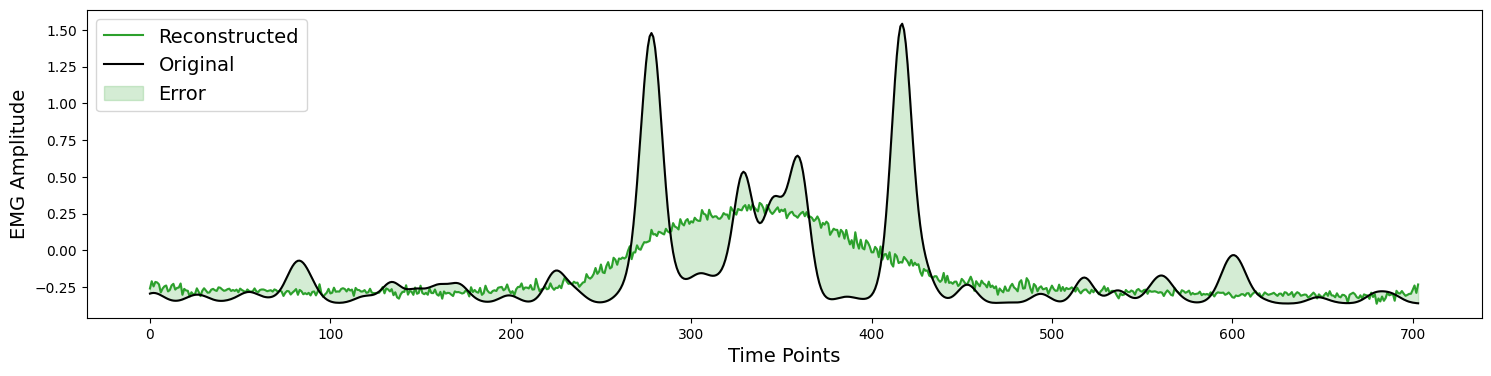

In [ ]:
loader = get_dataloader(test_data, batch_size=1, shuffle=True, k=0)
signals, labels = next(iter(loader))

print(f'Ground truth: {int(labels[0].item())}')
model.plot_reconstruction(signals, index=0)

In [ ]:
evals_test, evals_train = leave_one_subject_out_CV(model=EMG_CNN, config=emg_config, signals=['emg_trapezius'], batch_size=emg_config['batch_size'], mp_filter=emg_config['mp_filter'], resample_length=2816/4, emg_envelope=True)
report(evals_test, evals_train, percentile=85)

method       acc                prec            \
                              NaN       avg       std       avg       std   
0   test_supervised_acc_threshold  0.658621  0.123748  0.716848  0.184778   
1  train_supervised_acc_threshold  0.550862  0.100676  0.471428  0.372898   
2      fixed_percentile_threshold  0.556034  0.113460  0.455938  0.393735   
3                mixmod_threshold  0.539943  0.093269  0.506065  0.194067   
4                filter_threshold  0.541954  0.094496  0.468577  0.419961   
5                 karch_threshold  0.554023  0.106125  0.465600  0.379427   
6                    eb_threshold  0.531034  0.084160  0.353670  0.408808   

        rec                 auc           threshold           percentile  \
        avg       std       avg       std       avg       std        avg   
0  0.651149  0.296336  0.600517  0.189362  0.323173  1.472125  61.609195   
1  0.294253  0.339999  0.600517  0.189362  0.064465  0.027422  81.232959   
2  0.262069  0.321541  0.600517  0.189362  0.108648  0.082392        NaN   
3  0.674138  0.362452  0.600517  0.189362  0.003511  0.001418        NaN   
4  0.186782  0.273490  0.600517  0.189362  0.231263  0.083226        NaN   
5  0.268966  0.318423  0.600517  0.189362  0.080580  0.012106        NaN   
6  0.137931  0.241400  0.600517  0.189362  0.462649  0.087948        NaN   

              
         std  
0  30.394856  
1   3.850250  
2        NaN  
3        NaN  
4        NaN  
5        NaN  
6        NaN

## ECG

### 1. Cross subject and no subject specific context

In [3]:
df = load_data(filtered=True)
df = preprocess(df, resample_length=2816/2) # 1408

In [4]:
batch_size = 128
mp_filter = 0.25
k=0
signals = ['ecg']

# for training
train_data_normal, _ = prepare_data(df, signals, classes=[0], train_subjects=Subjects.train, test_subjects=Subjects.val, mp_filter=mp_filter)
train_loader_normal = get_dataloader(train_data_normal, batch_size=batch_size, shuffle=True,  k=k)

# for validation
_, test_data = prepare_data(df, signals, classes=[0, 4], train_subjects=Subjects.train, test_subjects=Subjects.val, mp_filter=mp_filter)
test_loader = get_dataloader(test_data, batch_size=batch_size, shuffle=False , k=k)

# for testing with training data
_, val_train_data = prepare_data(df, train_subjects=Subjects.val, test_subjects=Subjects.all, signals=signals, classes=[0, 4], mp_filter=mp_filter)
val_train_loader = get_dataloader(val_train_data, batch_size=batch_size, shuffle=False, k=k)

Epoch 1/150 - Train loss: 0.9984 - Val loss normal: 0.9035 - Val loss anomaly: 1.0009 - Val AUC: 0.5070
Epoch 2/150 - Train loss: 1.0104 - Val loss normal: 0.9011 - Val loss anomaly: 0.9980 - Val AUC: 0.5069
Epoch 3/150 - Train loss: 0.9633 - Val loss normal: 0.8980 - Val loss anomaly: 0.9946 - Val AUC: 0.5069
Epoch 4/150 - Train loss: 0.9841 - Val loss normal: 0.8980 - Val loss anomaly: 0.9947 - Val AUC: 0.5069
Epoch 5/150 - Train loss: 1.0006 - Val loss normal: 0.8977 - Val loss anomaly: 0.9943 - Val AUC: 0.5069
Epoch 6/150 - Train loss: 0.9946 - Val loss normal: 0.8977 - Val loss anomaly: 0.9943 - Val AUC: 0.5069
Epoch 7/150 - Train loss: 0.9833 - Val loss normal: 0.8977 - Val loss anomaly: 0.9943 - Val AUC: 0.5068
Epoch 8/150 - Train loss: 0.9686 - Val loss normal: 0.8977 - Val loss anomaly: 0.9942 - Val AUC: 0.5069
Epoch 9/150 - Train loss: 0.9714 - Val loss normal: 0.8970 - Val loss anomaly: 0.9935 - Val AUC: 0.5069
Epoch 10/150 - Train loss: 0.9701 - Val loss normal: 0.8654 - Va

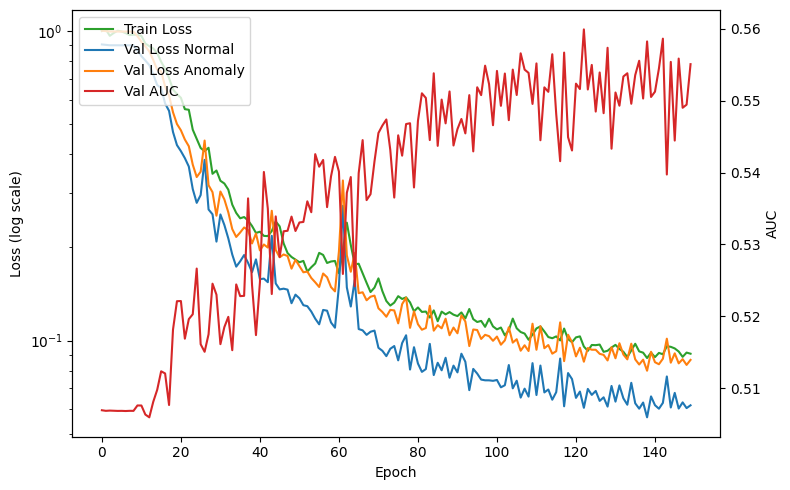

Best AUC: 0.5599 at epoch 123


In [48]:
ecg_config = {
    'crop_size': 256,
    'crop_begin': True,
    'add_noise_channels': [0],
    'max_noise': 0.2,
    'conv': {'ker': 11, 'pad': 5},
    'enc_dropout': 0,
    'dec_dropout': 0.1,
    'activation': 'relu',
    'batch_norm': False,
    'latent_dim': 64,
    'lr': 0.001,
    'batch_size': 128,
    'epochs': 150,
    'mp_filter': 0.25
}

model = ECG_CNN(ecg_config)
train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores, evaluation = model.train_model(train_loader_normal, val_loader=test_loader)
plot_losses_and_auc(train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores)

Ground truth: 1
Reconstruction error: 0.051107876002788544


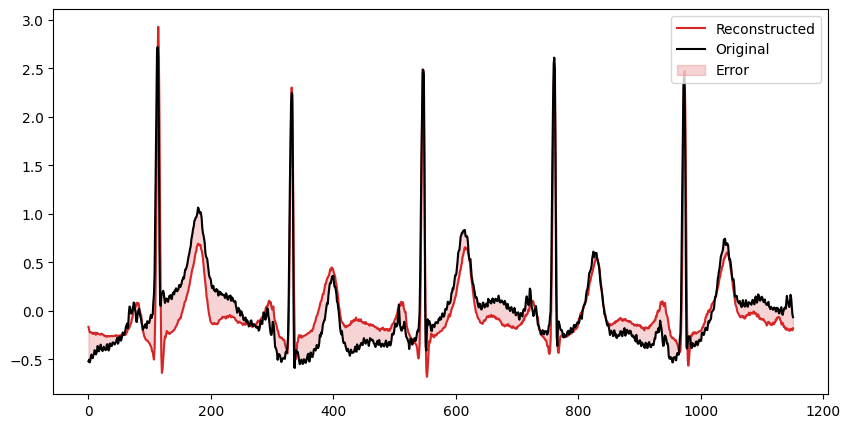

In [54]:
loader = get_dataloader(test_data, batch_size=1, shuffle=True, k=0)
signals, labels = next(iter(loader))

print(f'Ground truth: {int(labels[0].item())}')
model.plot_reconstruction(signals, index=0)

Ground truth: 1
Reconstruction error: 0.15817250311374664


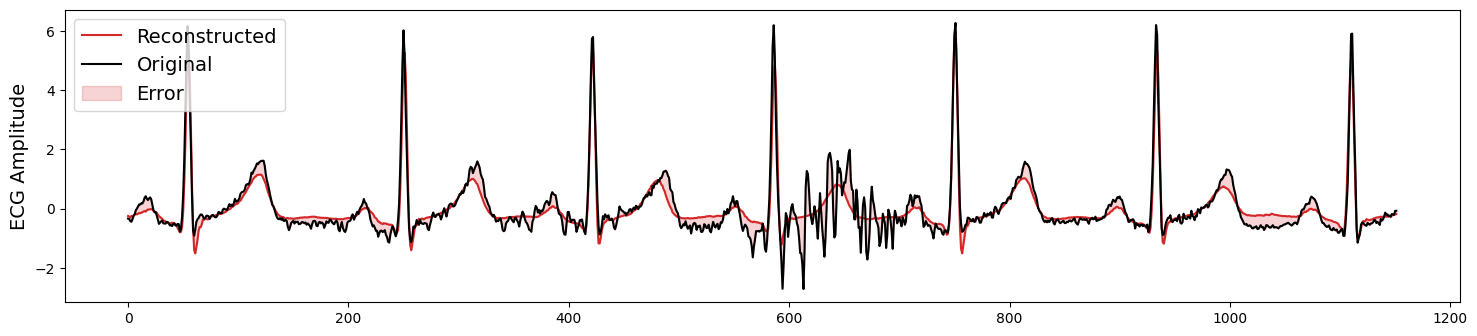

In [ ]:
loader = get_dataloader(test_data, batch_size=1, shuffle=True, k=0)
signals, labels = next(iter(loader))

print(f'Ground truth: {int(labels[0].item())}')
model.plot_reconstruction(signals, index=0)

In [ ]:
evals_test, evals_train = leave_one_subject_out_CV(model=ECG_CNN, config=ecg_config, signals=['ecg'], batch_size=ecg_config['batch_size'], mp_filter=ecg_config['mp_filter'])
report(evals_test, evals_train, percentile=55)

method       acc                prec            \
                              NaN       avg       std       avg       std   
0   test_supervised_acc_threshold  0.684195  0.136937  0.729254  0.204272   
1  train_supervised_acc_threshold  0.537356  0.103660  0.413842  0.344545   
2      fixed_percentile_threshold  0.547126  0.109559  0.520319  0.292609   
3                mixmod_threshold  0.509195  0.039956  0.109195  0.307243   
4                filter_threshold  0.512356  0.046559  0.155720  0.348056   
5                 karch_threshold  0.512644  0.051399  0.217466  0.371332   
6                    eb_threshold  0.501724  0.009123  0.045977  0.209435   

        rec                 auc           threshold           percentile  \
        avg       std       avg       std       avg       std        avg   
0  0.627586  0.304446  0.637529  0.197357  0.029362  0.022548  69.080460   
1  0.401149  0.437730  0.637529  0.197357  0.031738  0.012707  75.402299   
2  0.591379  0.416692  0.637529  0.197357  0.021211  0.007171        NaN   
3  0.020115  0.079315  0.637529  0.197357  0.164689  0.049307        NaN   
4  0.033908  0.124912  0.637529  0.197357  0.121930  0.039939        NaN   
5  0.060920  0.168568  0.637529  0.197357  0.089356  0.021305        NaN   
6  0.003448  0.018247  0.637529  0.197357  0.422956  0.116242        NaN   

              
         std  
0  26.968785  
1  13.051690  
2        NaN  
3        NaN  
4        NaN  
5        NaN  
6        NaN

### 2. Subject specific

In [ ]:
batch_size = 8
mp_filter = 2

train_loader, train_loader_normal, test_loader = get_dataloaders_subject_specific(df, 'ecg', batch_size=batch_size, subject='080309_m_29', mp_filter=mp_filter, fold=3)

In [ ]:
ecg_ss_config = {
    'crop_size': 128,
    'add_noise_channels': [0],
    'max_noise': 0.1,
    'conv': {'ker': 11, 'pad': 5},
    'enc_dropout': 0,
    'dec_dropout': 0.1,
    'activation': 'relu',
    'batch_norm': False,
    'latent_dim': 32,
    'lr': 1e-4,
    'batch_size': 8,
    'epochs': 200,
    'mp_filter': 2
}

model = ECG_CNNAutoencoder(ecg_ss_config)
train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores, evaluation = model.train_model(train_loader_normal, val_loader=test_loader)

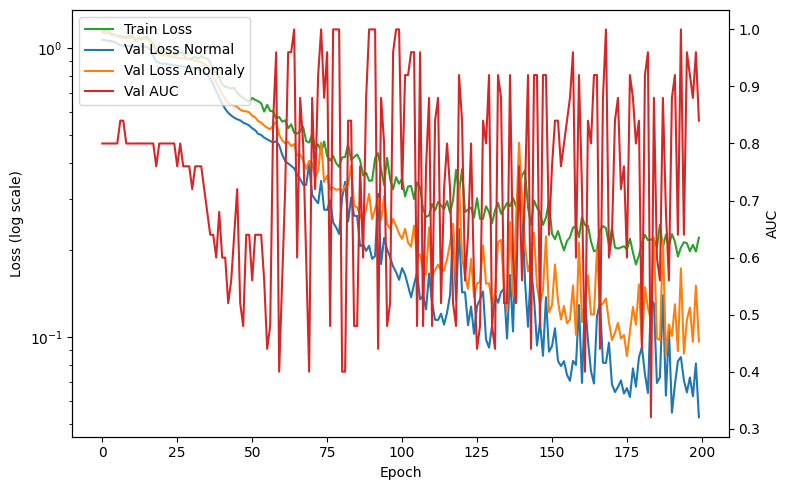

Best AUC: 1.0000 at epoch 65


In [84]:
plot_losses_and_auc(train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores)

Ground truth: 0
Reconstruction error: 0.10553812980651855


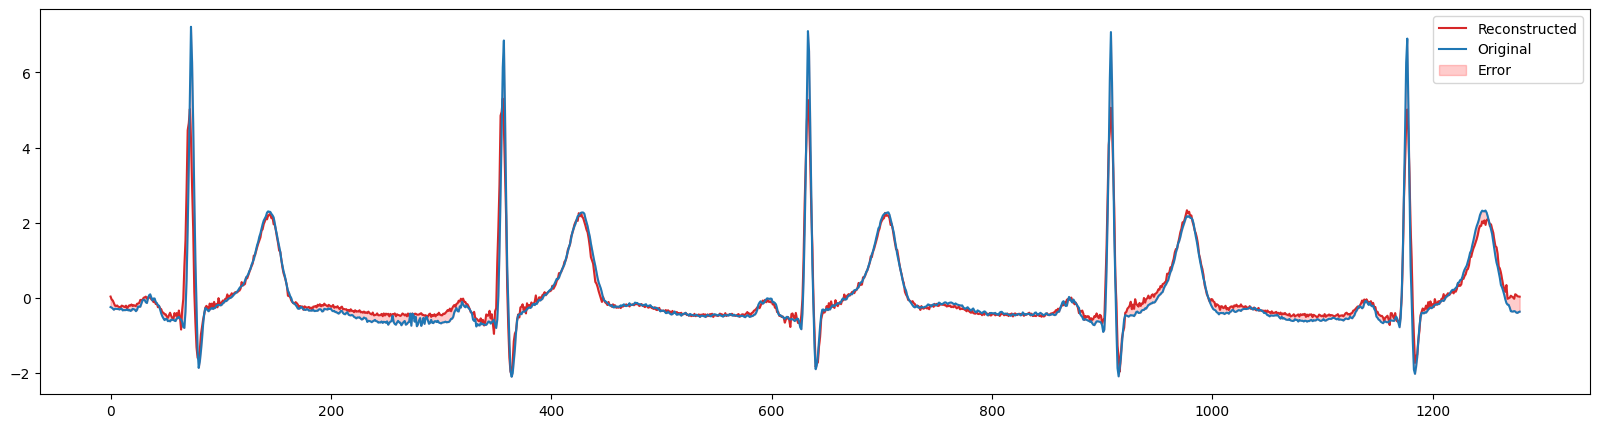

In [89]:
signals, labels = next(iter(train_loader))
print(f'Ground truth: {int(labels[0].item())}')
model.plot_reconstruction(signals[0].unsqueeze(0), figsize=(20, 5))

In [ ]:
evals_test, evals_train = subject_specific_CV(model=ECG_CNNAutoencoder, subjects=Subjects.all, config=ecg_ss_config, signal='ecg', batch_size=ecg_ss_config['batch_size'], mp_filter=ecg_ss_config['mp_filter'], resample_length=2816/2)

report(evals_test, evals_train, percentile=55)

method       acc                prec            \
                              NaN       avg       std       avg       std   
0   test_supervised_acc_threshold  0.693103  0.130246  0.717193  0.282325   
1  train_supervised_acc_threshold  0.581897  0.137045  0.570923  0.162957   
2      fixed_percentile_threshold  0.545402  0.167492  0.533048  0.223340   
3                mixmod_threshold  0.507759  0.062262  0.106529  0.285249   
4                filter_threshold  0.504885  0.028451  0.047140  0.205472   
5                 karch_threshold  0.506034  0.034630  0.063903  0.238830   
6                    eb_threshold  0.505747  0.045754  0.077025  0.251780   

        rec                 auc           threshold           percentile  \
        avg       std       avg       std       avg       std        avg   
0  0.631034  0.326180  0.566552  0.224578  0.107434  0.104001  55.517241   
1  0.824138  0.242338  0.566552  0.224578  0.074715  0.060933  39.655172   
2  0.582759  0.299696  0.566552  0.224578  0.088620  0.067302        NaN   
3  0.054598  0.169877  0.566552  0.224578  0.388987  0.130484        NaN   
4  0.014943  0.072760  0.566552  0.224578  0.670528  0.164734        NaN   
5  0.019540  0.080714  0.566552  0.224578  0.542825  0.103924        NaN   
6  0.032759  0.123019  0.566552  0.224578  0.436888  0.158771        NaN   

              
         std  
0  27.218090  
1  28.349824  
2        NaN  
3        NaN  
4        NaN  
5        NaN  
6        NaN

## EDA, EMG, ECG

In [52]:
df = load_data(filtered=True)
df = preprocess(df, emg_envelope=True, resample_length=2816/2) # 1408

In [72]:
batch_size = 128
mp_filter = 0.25
k=0
signals = ['gsr', 'ecg', 'emg_trapezius']

# for training
train_data_normal, _ = prepare_data(df, signals, classes=[0], train_subjects=Subjects.train, test_subjects=Subjects.val, mp_filter=mp_filter)
train_loader_normal = get_dataloader(train_data_normal, batch_size=batch_size, shuffle=True,  k=k)

# for validation
_, test_data = prepare_data(df, signals, classes=[0, 4], train_subjects=Subjects.train, test_subjects=Subjects.val, mp_filter=mp_filter)
test_loader = get_dataloader(test_data, batch_size=batch_size, shuffle=False , k=k)

# for testing with training data
_, val_train_data = prepare_data(df, train_subjects=Subjects.val, test_subjects=Subjects.all, signals=signals, classes=[0, 4], mp_filter=mp_filter)
val_train_loader = get_dataloader(val_train_data, batch_size=batch_size, shuffle=False, k=k)

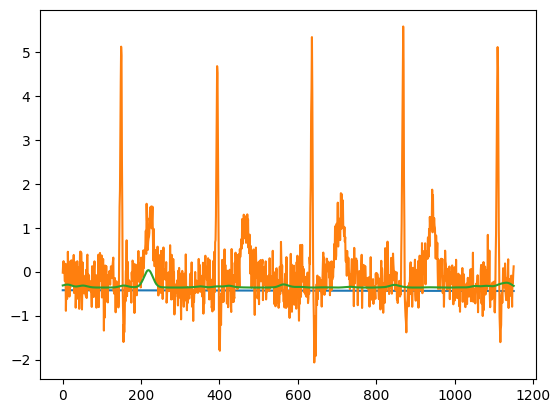

Epoch 1/80 - Train loss: 0.7976 - Val loss normal: 1.1981 - Val loss anomaly: 2.0114 - Val AUC: 0.5145
Epoch 2/80 - Train loss: 0.7414 - Val loss normal: 1.1260 - Val loss anomaly: 1.9441 - Val AUC: 0.5186
Epoch 3/80 - Train loss: 0.7115 - Val loss normal: 1.1067 - Val loss anomaly: 1.9200 - Val AUC: 0.5191
Epoch 4/80 - Train loss: 0.6492 - Val loss normal: 1.0744 - Val loss anomaly: 1.8831 - Val AUC: 0.5197
Epoch 5/80 - Train loss: 0.5286 - Val loss normal: 1.0146 - Val loss anomaly: 1.7930 - Val AUC: 0.5190
Epoch 6/80 - Train loss: 0.4589 - Val loss normal: 1.0020 - Val loss anomaly: 1.7811 - Val AUC: 0.5198
Epoch 7/80 - Train loss: 0.4605 - Val loss normal: 0.9939 - Val loss anomaly: 1.7685 - Val AUC: 0.5215
Epoch 8/80 - Train loss: 0.4406 - Val loss normal: 0.9817 - Val loss anomaly: 1.7522 - Val AUC: 0.5211
Epoch 9/80 - Train loss: 0.4304 - Val loss normal: 0.9762 - Val loss anomaly: 1.7466 - Val AUC: 0.5210
Epoch 10/80 - Train loss: 0.4249 - Val loss normal: 0.9768 - Val loss ano

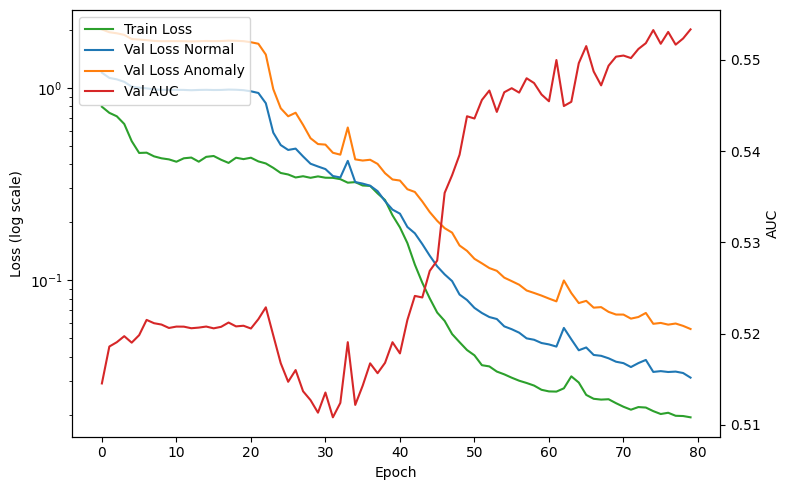

Best AUC: 0.5533 at epoch 80


In [88]:
config = {
    'crop_size': 256,
    'crop_begin': True,
    'add_noise_channels': [1],
    'max_noise': 0.8,
    'conv': {'ker': 5, 'pad': 2},
    'enc_dropout': 0,
    'dec_dropout': 0,
    'activation': 'relu',
    'batch_norm': False,
    'latent_dim': 8,
    'lr': 1e-3,
    'batch_size': 128,
    'epochs': 80,
    'mp_filter': 0.25,
    'print': True,
}

model = CNN(config)
train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores, evaluation = model.train_model(train_loader_normal, val_loader=test_loader)
plot_losses_and_auc(train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores)

Ground truth: 1
Reconstruction error: 0.020280348137021065


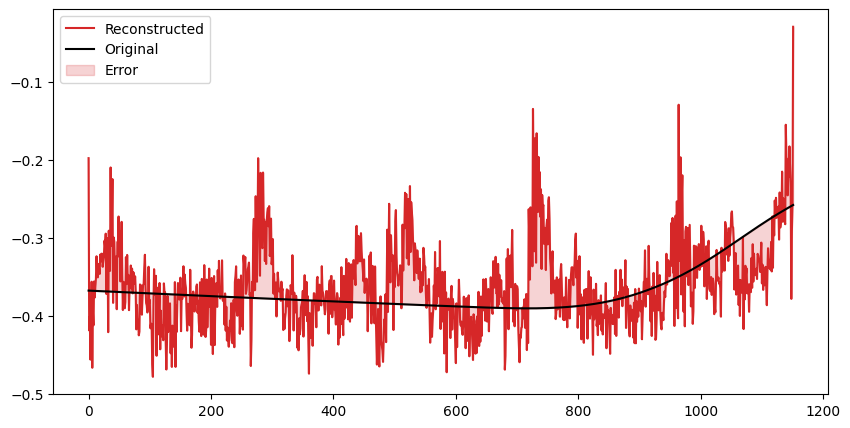

Reconstruction error: 0.0179453082382679


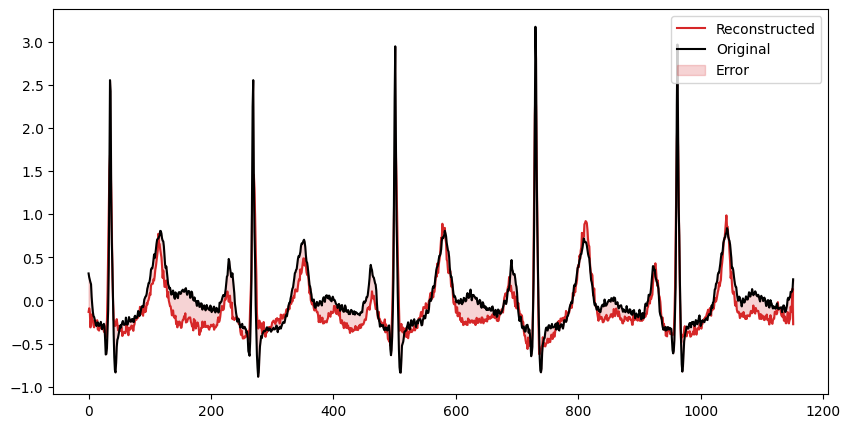

Reconstruction error: 0.020997304469347


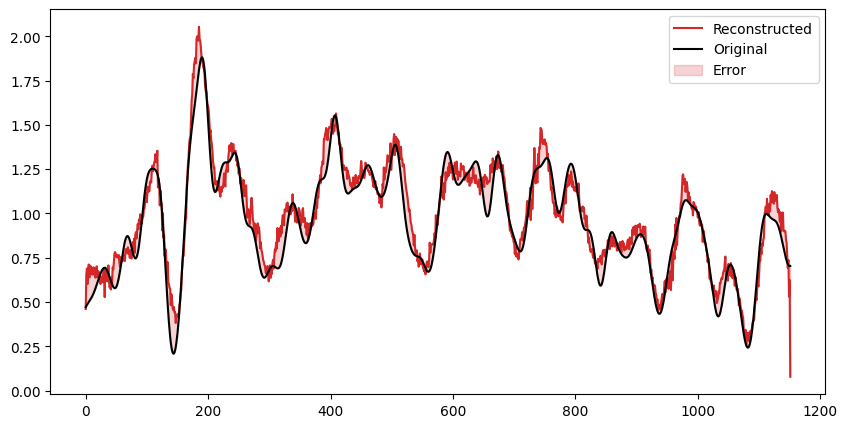

In [91]:
loader = get_dataloader(test_data, batch_size=1, shuffle=True, k=0)
signals, labels = next(iter(loader))

print(f'Ground truth: {int(labels[0].item())}')
model.plot_reconstruction(signals, index=0)
model.plot_reconstruction(signals, index=1)
model.plot_reconstruction(signals, index=2)

In [8]:
evals_test, evals_train = leave_one_subject_out_CV(model=CNN, config=config, signals=['gsr','ecg', 'emg_trapezius'], batch_size=config['batch_size'], mp_filter=config['mp_filter'])
report(evals_test, evals_train, percentile=73)

method       acc                prec            \
                              NaN       avg       std       avg       std   
0   test_supervised_acc_threshold  0.670690  0.133811  0.720075  0.190421   
1  train_supervised_acc_threshold  0.560632  0.108915  0.493093  0.326474   
2      fixed_percentile_threshold  0.560632  0.108187  0.495594  0.326371   
3                mixmod_threshold  0.510920  0.057072  0.511107  0.052491   
4                filter_threshold  0.561207  0.115455  0.463636  0.351055   
5                 karch_threshold  0.564655  0.116248  0.493971  0.339171   
6                    eb_threshold  0.536494  0.093680  0.384482  0.412686   

        rec                 auc           threshold           percentile  \
        avg       std       avg       std       avg       std        avg   
0  0.627586  0.297958  0.615489  0.203152  0.278141  1.081690  66.379310   
1  0.412644  0.395173  0.615489  0.203152  0.043663  0.018779  73.061347   
2  0.412069  0.391502  0.615489  0.203152  0.042394  0.007415        NaN   
3  0.933333  0.157507  0.615489  0.203152  0.005786  0.001727        NaN   
4  0.337356  0.356566  0.615489  0.203152  0.070751  0.004793        NaN   
5  0.374138  0.368740  0.615489  0.203152  0.053498  0.003228        NaN   
6  0.157471  0.258035  0.615489  0.203152  0.491122  0.125745        NaN   

              
         std  
0  27.372375  
1   2.421245  
2        NaN  
3        NaN  
4        NaN  
5        NaN  
6        NaN